#### AAPL PRICE PREDICTION USING LSTM

In [121]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import quandl
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import os 
from time import strftime
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
#nasdaq data
import nasdaqdatalink

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
print(np.__version__)
print(tf.__version__)
!python --version

1.19.5
2.3.0
Python 3.7.11


In [140]:
from IPython.display import display, Markdown
def subtitle(t):
    display(Markdown(f'<br>**{t}**'))
    
    
def np_print(*args, precision=3, linewidth=120):
    with np.printoptions(precision=precision, linewidth=linewidth):
        for a in args:
            print(a)

##### Parameters

In [180]:
# ---- About dataset (no need to change)
#
Logging_path = r"D:/Deep-Learning/stock-price-LSTM/"
run_dir = './run/stock-pred'
dataset_dir      = './data'                  # Enhanced dataset is very small, so ./data in a good choice :-)
dataset_filename = 'stock_data.csv'
schema_filename  = 'stock_data.json'

features         = ['10ty', 'eurusd', 'gdpusd', 'spy', 'aapl']
features_len     = len(features)

# ---- About training (Can be changed !)
#
scale            = 1        # Percentage of dataset to be used (1=all)
train_prop       = .8       # Percentage for train (the rest being for the test)
sequence_len     = 10
batch_size       = 20
epochs           = 10
fit_verbosity    = 1        # 0 = silent, 1 = progress bar, 2 = one line per epoch

In [5]:
start_date = '2010-03-01'
end_date = '2020-09-01'

In [6]:
nasdaq_api_key="K9PTs-VpVCsxdc2H1Zw7" 

In [7]:
nasdaqdatalink.ApiConfig.api_key = nasdaq_api_key

In [8]:
ty_10 = nasdaqdatalink.get("FRED/DGS10", start_date=start_date, end_date=end_date)

In [9]:
print(ty_10.shape)
ty_10.head()

(2632, 1)


,Value
Date,
2010-03-01,3.61
2010-03-02,3.62
2010-03-03,3.63
2010-03-04,3.61
2010-03-05,3.69


In [10]:
quandl_key="HeSenjS7xyCu9Kw3-sBs"

In [11]:
quandl.ApiConfig.api_key = quandl_key

In [12]:
aaple = quandl.get('WIKI/AAPL',start_date=start_date,end_date=end_date, collapse="daily")
aaple.reset_index(inplace=True)

In [13]:
print(aaple.shape)
aaple.tail()

(2032, 13)


,Date,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
2027,2018-03-21,175.04,175.09,171.26,171.270,35247358.0,0.0,1.0,175.04,175.09,171.26,171.270,35247358.0
2028,2018-03-22,170.00,172.68,168.60,168.845,41051076.0,0.0,1.0,170.00,172.68,168.60,168.845,41051076.0
2029,2018-03-23,168.39,169.92,164.94,164.940,40248954.0,0.0,1.0,168.39,169.92,164.94,164.940,40248954.0
2030,2018-03-26,168.07,173.10,166.44,172.770,36272617.0,0.0,1.0,168.07,173.10,166.44,172.770,36272617.0
2031,2018-03-27,173.68,175.15,166.92,168.340,38962839.0,0.0,1.0,173.68,175.15,166.92,168.340,38962839.0


In [14]:
import pandas_datareader as pdr

In [15]:
auth_key = "43476b4df00e1fd473c482b1943e2f9f099d9ec2"

In [16]:
eurusd = pdr.get_data_tiingo("eurusd", 
                             start=start_date, 
                             end=end_date, 
                             freq='daily',
                             api_key = auth_key)

In [17]:
eurusd = eurusd.loc[:, "adjClose"]
eurusd

symbol  date                     
eurusd  2010-03-01 00:00:00+00:00    1.347891
        2010-03-02 00:00:00+00:00    1.356116
        2010-03-03 00:00:00+00:00    1.369113
        2010-03-04 00:00:00+00:00    1.360915
        2010-03-05 00:00:00+00:00    1.360729
                                       ...   
        2020-08-28 00:00:00+00:00    1.190480
        2020-08-30 00:00:00+00:00    1.191790
        2020-08-31 00:00:00+00:00    1.193690
        2020-09-01 00:00:00+00:00    1.192250
        2020-09-02 00:00:00+00:00    1.184590
Name: adjClose, Length: 2814, dtype: float64

In [18]:
gdpusd = pdr.get_data_tiingo("GBPUSD", 
                             start=start_date, 
                             end=end_date, 
                             freq='daily',
                             api_key = auth_key)

In [19]:
gdpusd=gdpusd.loc[:, "adjClose"]
gdpusd

symbol  date                     
GBPUSD  2010-03-01 00:00:00+00:00    1.49390
        2010-03-02 00:00:00+00:00    1.49270
        2010-03-03 00:00:00+00:00    1.50680
        2010-03-04 00:00:00+00:00    1.50540
        2010-03-05 00:00:00+00:00    1.51020
                                      ...   
        2020-08-28 00:00:00+00:00    1.33516
        2020-08-30 00:00:00+00:00    1.33556
        2020-08-31 00:00:00+00:00    1.33639
        2020-09-01 00:00:00+00:00    1.33998
        2020-09-02 00:00:00+00:00    1.33482
Name: adjClose, Length: 2815, dtype: float64

In [ ]:
# eurusd.to_csv("eurusd", sep=";", index=False, header=True)

In [20]:
spy = pdr.get_data_tiingo("SPY", 
                          start=start_date, 
                          end=end_date, 
                          freq='daily', 
                          api_key = auth_key)

In [21]:
spy.reset_index(inplace=True)

In [22]:
spy['date'] = pd.to_datetime(spy['date'])

In [23]:
spy = spy.loc[: ,["date", "adjClose"]]
spy

,date,adjClose
0,2010-03-01 00:00:00+00:00,88.415139
1,2010-03-02 00:00:00+00:00,88.660100
2,2010-03-03 00:00:00+00:00,88.739120
3,2010-03-04 00:00:00+00:00,89.007786
4,2010-03-05 00:00:00+00:00,90.280004
...,...,...
2642,2020-08-26 00:00:00+00:00,339.075641
2643,2020-08-27 00:00:00+00:00,339.817067
2644,2020-08-28 00:00:00+00:00,342.012079
2645,2020-08-31 00:00:00+00:00,340.773116


In [24]:
cols = ["Date", "Adj. Close"]
aapl = aaple[cols]
print(aapl.shape)
aapl.tail()

(2032, 2)


,Date,Adj. Close
2027,2018-03-21,171.270
2028,2018-03-22,168.845
2029,2018-03-23,164.940
2030,2018-03-26,172.770
2031,2018-03-27,168.340


In [25]:
aapl_10y = pd.merge(aapl, ty_10, how="inner", on="Date")
aapl_10y = aapl_10y.rename(columns={"Adj. Close": "aapl", "Value": "10ty"})

In [78]:
#aapl_10y.reset_index(inplace=True)

In [26]:
usdeurgdp = pd.merge(eurusd, gdpusd, how="inner", on="date")

In [27]:
usdeurgdpspy = pd.merge(usdeurgdp, spy, how="inner", on="date")

In [28]:
usdeurgdpspy = usdeurgdpspy.rename(columns={"date": "Date", "adjClose_x": "eurusd", "adjClose_y": "gdpusd", "adjClose": "spy"})

In [29]:
usdeurgdpspy

,Date,eurusd,gdpusd,spy
0,2010-03-01 00:00:00+00:00,1.347891,1.49390,88.415139
1,2010-03-02 00:00:00+00:00,1.356116,1.49270,88.660100
2,2010-03-03 00:00:00+00:00,1.369113,1.50680,88.739120
3,2010-03-04 00:00:00+00:00,1.360915,1.50540,89.007786
4,2010-03-05 00:00:00+00:00,1.360729,1.51020,90.280004
...,...,...,...,...
2871,2020-08-26 00:00:00+00:00,1.184020,1.32190,339.075641
2872,2020-08-27 00:00:00+00:00,1.182050,1.31995,339.817067
2873,2020-08-28 00:00:00+00:00,1.190480,1.33516,342.012079
2874,2020-08-31 00:00:00+00:00,1.193690,1.33639,340.773116


In [30]:
usdeurgdpspy["Date"] = usdeurgdpspy["Date"].dt.strftime("%Y-%m-%d")
usdeurgdpspy['Date'] = pd.to_datetime(usdeurgdpspy['Date'])

In [31]:
usdeurgdpspy

,Date,eurusd,gdpusd,spy
0,2010-03-01,1.347891,1.49390,88.415139
1,2010-03-02,1.356116,1.49270,88.660100
2,2010-03-03,1.369113,1.50680,88.739120
3,2010-03-04,1.360915,1.50540,89.007786
4,2010-03-05,1.360729,1.51020,90.280004
...,...,...,...,...
2871,2020-08-26,1.184020,1.32190,339.075641
2872,2020-08-27,1.182050,1.31995,339.817067
2873,2020-08-28,1.190480,1.33516,342.012079
2874,2020-08-31,1.193690,1.33639,340.773116


In [32]:
usdeurgdpspy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2876 entries, 0 to 2875
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2876 non-null   datetime64[ns]
 1   eurusd  2876 non-null   float64       
 2   gdpusd  2876 non-null   float64       
 3   spy     2876 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 112.3 KB


In [33]:
aapl_10y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2017 entries, 0 to 2016
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2017 non-null   datetime64[ns]
 1   aapl    2017 non-null   float64       
 2   10ty    2017 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 63.0 KB


In [34]:
#fin_data = pd.merge(aapl_10y, usdeurgdpspy, how="inner", on="Date")
stock_data = pd.merge(aapl_10y, usdeurgdpspy, on="Date", how="inner")

In [35]:
stock_data

,Date,aapl,10ty,eurusd,gdpusd,spy
0,2010-03-01,26.858128,3.61,1.347891,1.4939,88.415139
1,2010-03-02,26.840136,3.62,1.356116,1.4927,88.660100
2,2010-03-03,26.901823,3.63,1.369113,1.5068,88.739120
3,2010-03-04,27.079172,3.61,1.360915,1.5054,89.007786
4,2010-03-05,28.138127,3.69,1.360729,1.5102,90.280004
...,...,...,...,...,...,...
1975,2018-03-21,171.270000,2.89,1.226693,1.4062,252.405515
1976,2018-03-22,168.845000,2.83,1.231224,1.4099,246.096077
1977,2018-03-23,164.940000,2.82,1.235941,1.4150,240.850657
1978,2018-03-26,172.770000,2.85,1.244245,1.4223,247.440099


In [36]:
#Separate dates for future plotting
train_dates = pd.to_datetime(stock_data['Date'])
print(train_dates.tail(5)) #Check last few dates. 

1975   2018-03-21
1976   2018-03-22
1977   2018-03-23
1978   2018-03-26
1979   2018-03-27
Name: Date, dtype: datetime64[ns]


In [134]:
#stock_data.set_index("Date", inplace = True)

In [50]:
sp500dy=quandl.get("MULTPL/SP500_DIV_YIELD_MONTH",start_date=start_date, end_date=end_date)
sp500dy = sp500dy.rename(columns={"Value": "sp500dy"})
print(sp500dy.shape)
sp500dy.head()

(133, 1)


,sp500dy
Date,
2010-03-31,1.90
2010-04-30,1.83
2010-05-31,1.95
2010-06-30,2.03
2010-07-31,2.05


In [99]:
# stock_data = np.log(stock_data/stock_data.shift(1))
# stock_data = stock_data.iloc[1:, :]
# print(stock_data.shape)
# stock_data.head()

(1979, 5)


,aapl,10ty,eurusd,gdpusd,spy
Date,,,,,
2010-03-02,-0.000670,0.002766,0.006084,-0.000804,0.002767
2010-03-03,0.002296,0.002759,0.009538,0.009402,0.000891
2010-03-04,0.006571,-0.005525,-0.006006,-0.000930,0.003023
2010-03-05,0.038361,0.021919,-0.000136,0.003183,0.014192
2010-03-08,0.000594,0.008097,0.003271,-0.002121,0.000175


In [151]:
#reset index
#stock_data.reset_index(inplace=True)

In [37]:
stock_data_ori = stock_data.copy()

In [38]:
stock_data = stock_data.iloc[:, 1:].astype(float)

In [44]:
stock_data

,aapl,10ty,eurusd,gdpusd,spy
0,26.858128,3.61,1.347891,1.4939,88.415139
1,26.840136,3.62,1.356116,1.4927,88.660100
2,26.901823,3.63,1.369113,1.5068,88.739120
3,27.079172,3.61,1.360915,1.5054,89.007786
4,28.138127,3.69,1.360729,1.5102,90.280004
...,...,...,...,...,...
1975,171.270000,2.89,1.226693,1.4062,252.405515
1976,168.845000,2.83,1.231224,1.4099,246.096077
1977,164.940000,2.82,1.235941,1.4150,240.850657
1978,172.770000,2.85,1.244245,1.4223,247.440099


In [129]:
stock_data = stock_data[['10ty', 'eurusd', 'gdpusd', 'spy', 'aapl']]

In [130]:
stock_data.head()

,10ty,eurusd,gdpusd,spy,aapl
0,3.61,1.347891,1.4939,88.415139,26.858128
1,3.62,1.356116,1.4927,88.660100,26.840136
2,3.63,1.369113,1.5068,88.739120,26.901823
3,3.61,1.360915,1.5054,89.007786,27.079172
4,3.69,1.360729,1.5102,90.280004,28.138127


In [131]:
#stock_data.to_csv("stock_data.csv", header=True, index=False)

In [185]:
stock_data = pd.read_csv("stock_data.csv")

In [184]:
stock_data = stock_data[:int(scale*len(stock_data))]
train_len=int(train_prop*len(stock_data))

# # ---- Train / Test
dataset_train = stock_data.loc[ :train_len-1, features ]
dataset_test  = stock_data.loc[train_len:,    features ]

subtitle('Dataset example :')
display(stock_data.head(5))

# ---- Normalize, and convert to numpy array

mean = dataset_train.mean()
std  = dataset_train.std()
dataset_train = (dataset_train - mean) / std
dataset_test = (dataset_test - mean) / std

subtitle('After normalization :')
display(dataset_train.describe().style.format("{0:.2f}"))

dataset_train = dataset_train.to_numpy()
dataset_test  = dataset_test.to_numpy()

print('Dataset            : ',stock_data.shape)
print('Dataset train      : ',dataset_train.shape)
print('Dataset test       : ',dataset_test.shape)

<br>**Dataset example :**

,10ty,eurusd,gdpusd,spy,aapl
0,3.61,1.347891,1.4939,88.415139,26.858128
1,3.62,1.356116,1.4927,88.660100,26.840136
2,3.63,1.369113,1.5068,88.739120,26.901823
3,3.61,1.360915,1.5054,89.007786,27.079172
4,3.69,1.360729,1.5102,90.280004,28.138127


<br>**After normalization :**

,10ty,eurusd,gdpusd,spy,aapl
count,1584.00,1584.00,1584.00,1584.00,1584.00
mean,-0.00,-0.00,0.00,0.00,0.00
std,1.00,1.00,1.00,1.00,1.00
min,-1.75,-2.08,-3.69,-1.64,-1.72
25%,-0.77,-0.79,-0.51,-0.92,-0.86
50%,-0.21,0.29,0.07,-0.03,-0.08
75%,0.61,0.76,0.66,0.99,0.81
max,2.81,1.99,2.08,1.67,1.97


Dataset            :  (1980, 5)
Dataset train      :  (1584, 5)
Dataset test       :  (396, 5)


In [186]:
dataset_train[0:15]

array([[ 2.1598426 ,  0.67879016, -0.92320585, -1.44084178, -1.71518588],
       [ 2.17730389,  0.75545866, -0.93939166, -1.43383703, -1.71584839],
       [ 2.19476518,  0.87659854, -0.74920842, -1.43157744, -1.71357693],
       [ 2.1598426 ,  0.80018405, -0.76809186, -1.42389481, -1.70704651],
       [ 2.29953292,  0.79845799, -0.70334863, -1.38751531, -1.66805325],
       [ 2.35191679,  0.84001347, -0.74651078, -1.3870634 , -1.66743806],
       [ 2.3344555 ,  0.77434239, -0.86116026, -1.38277016, -1.64879323],
       [ 2.36937808,  0.85218516, -0.88139252, -1.37124622, -1.64018064],
       [ 2.36937808,  0.85915088, -0.78427767, -1.36040016, -1.63705739],
       [ 2.3344555 ,  0.93980767, -0.59948969, -1.3601742 , -1.63185198],
       [ 2.3344555 ,  0.84001347, -0.78427767, -1.35949632, -1.64491283],
       [ 2.24714905,  0.93627963, -0.5846527 , -1.33870804, -1.6420262 ],
       [ 2.22968776,  0.92042743, -0.44302688, -1.32311683, -1.64358782],
       [ 2.28207163,  0.79328263, -0.5

In [160]:
#scaler = MinMaxScaler()
scaler = StandardScaler()
scaler = scaler.fit(stock_data)
stock_data_scaled = scaler.transform(stock_data)

#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 
#Empty lists to be populated using formatted training data
Xtrain = []
ytrain = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = sequence_len  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In this example, my df_for_training_scaled has a shape (1980, 5)
#1980 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(stock_data_scaled) - n_future +1):
    Xtrain.append(stock_data_scaled[i - n_past:i, 0:stock_data.shape[1]])
    ytrain.append(stock_data_scaled[i + n_future - 1:i + n_future, 0])

In [161]:
Xtrain, ytrain = np.array(Xtrain), np.array(ytrain)

print('Xtrain shape == {}.'.format(Xtrain.shape))
print('ytrain shape == {}.'.format(ytrain.shape))

Xtrain shape == (1966, 14, 5).
ytrain shape == (1966, 1).


In [119]:
def timeseries_prep(dataset, time_step=1):
    dataX, datay = [], []
    for i in range(len(dataset)-time_step-1):
        a= dataset[i:(i+time_step), 1:]
        dataX.append(a)
        datay.append(dataset[i + time_step, 1:])
    return np.array(dataX), np.array(datay)

In [ ]:
time_step = sequence_len
Xtrain, ytrain = timeseries_prep(dataset_train, time_step) 
Xtest, ytest = timeseries_prep(dataset_test, time_step)

In [ ]:
#In my case, trainX has a shape (1966, 14, 5). 
#1966 because we are looking back 14 days (1980 - 14 = 1966). 
#Remember that we cannot look back 14 days until we get to the 15th day. 
#Also, ytrain has a shape (1966, 1). Our model only predicts a single value, but 
#it needs multiple variables (5 in my example) to make this prediction. 
#This is why we can only predict a single day after our training, the day after where our data ends.
#To predict more days in future, we need all the 5 variables which we do not have. 
#We need to predict all variables if we want to do that.

In [188]:
train_generator = TimeseriesGenerator(dataset_train, dataset_train, length=sequence_len,  batch_size=batch_size)
test_generator  = TimeseriesGenerator(dataset_test,  dataset_test,  length=sequence_len,  batch_size=batch_size)

In [189]:
print('Samples: %d' % len(train_generator))
print('Samples: %d' % len(test_generator))

Samples: 79
Samples: 20


In [190]:
for i in range(len(train_generator)):
    x, y = train_generator[i]
    print('%s => %s' % (x, y))

[[[ 2.1598426   0.67879016 -0.92320585 -1.44084178 -1.71518588]
  [ 2.17730389  0.75545866 -0.93939166 -1.43383703 -1.71584839]
  [ 2.19476518  0.87659854 -0.74920842 -1.43157744 -1.71357693]
  [ 2.1598426   0.80018405 -0.76809186 -1.42389481 -1.70704651]
  [ 2.29953292  0.79845799 -0.70334863 -1.38751531 -1.66805325]
  [ 2.35191679  0.84001347 -0.74651078 -1.3870634  -1.66743806]
  [ 2.3344555   0.77434239 -0.86116026 -1.38277016 -1.64879323]
  [ 2.36937808  0.85218516 -0.88139252 -1.37124622 -1.64018064]
  [ 2.36937808  0.85915088 -0.78427767 -1.36040016 -1.63705739]
  [ 2.3344555   0.93980767 -0.59948969 -1.3601742  -1.63185198]]

 [[ 2.17730389  0.75545866 -0.93939166 -1.43383703 -1.71584839]
  [ 2.19476518  0.87659854 -0.74920842 -1.43157744 -1.71357693]
  [ 2.1598426   0.80018405 -0.76809186 -1.42389481 -1.70704651]
  [ 2.29953292  0.79845799 -0.70334863 -1.38751531 -1.66805325]
  [ 2.35191679  0.84001347 -0.74651078 -1.3870634  -1.66743806]
  [ 2.3344555   0.77434239 -0.86116026

[[[ 1.68838775  1.36078867  1.02988163 -0.97738193 -1.08954282]
  [ 1.72331033  1.27848418  0.83834957 -0.96882027 -1.09905452]
  [ 1.82807807  1.34950477  0.72504892 -0.94012714 -1.07170246]
  [ 1.89792324  1.2970998   0.6225388  -0.93087129 -1.04061196]
  [ 1.91538453  1.2636295   0.52272632 -0.93827597 -1.04581737]
  [ 1.9677684   1.22663906  0.47147126 -0.9179131  -1.04335663]
  [ 1.91538453  1.25436233  0.59286482 -0.89685604 -1.05438264]
  [ 1.91538453  1.34199285  0.54835385 -0.90102117 -1.05496233]
  [ 1.89792324  1.29896426  0.54835385 -0.88806299 -1.07364266]
  [ 1.88046195  1.38341428  0.70077021 -0.88551763 -1.08959014]]

 [[ 1.72331033  1.27848418  0.83834957 -0.96882027 -1.09905452]
  [ 1.82807807  1.34950477  0.72504892 -0.94012714 -1.07170246]
  [ 1.89792324  1.2970998   0.6225388  -0.93087129 -1.04061196]
  [ 1.91538453  1.2636295   0.52272632 -0.93827597 -1.04581737]
  [ 1.9677684   1.22663906  0.47147126 -0.9179131  -1.04335663]
  [ 1.91538453  1.25436233  0.59286482

 [-0.68634778  0.4461036   0.75876935 -0.65789587  0.17158626]]
[[[-0.61650261  0.30898799  0.35142652 -0.72924181  0.15989774]
  [-0.65142519  0.28987575  0.29342738 -0.73136802  0.04111973]
  [-0.59904132  0.36346667  0.40807685 -0.68341031  0.18105064]
  [-0.65142519  0.34578802  0.54970267 -0.69451382  0.17461486]
  [-0.68634778  0.36507636  0.58881837 -0.71553961  0.07571205]
  [-0.66888649  0.42655946  0.66570096 -0.71010598  0.00728456]
  [-0.72127036  0.34739307  0.63737579 -0.73751038  0.00122736]
  [-0.65142519  0.4216831   0.71021193 -0.72522565 -0.05281427]
  [-0.6339639   0.40383612  0.66030569 -0.68081162  0.1824703 ]
  [-0.68634778  0.4461036   0.75876935 -0.65789587  0.17158626]]

 [[-0.65142519  0.28987575  0.29342738 -0.73136802  0.04111973]
  [-0.59904132  0.36346667  0.40807685 -0.68341031  0.18105064]
  [-0.65142519  0.34578802  0.54970267 -0.69451382  0.17461486]
  [-0.68634778  0.36507636  0.58881837 -0.71553961  0.07571205]
  [-0.66888649  0.42655946  0.66570096

[[[-0.96572843  0.35060441 -0.30949397 -0.12459251 -0.61851885]
  [-1.08795746  0.3233616  -0.34591204 -0.13401119 -0.64027186]
  [-1.14034133  0.3121792  -0.42009699 -0.22288487 -0.68805165]
  [-1.08795746  0.35381744 -0.44842215 -0.16758033 -0.65736694]
  [-1.12288004  0.27082333 -0.52395592 -0.22312638 -0.76992555]
  [-1.14034133  0.30739302 -0.44842215 -0.24655232 -0.82154693]
  [-1.12288004  0.30739302 -0.49293313 -0.21419071 -0.82884595]
  [-1.14034133  0.26131946 -0.50911893 -0.19752689 -0.78975777]
  [-1.10541875  0.24551267 -0.45786388 -0.15864466 -0.75393493]
  [-1.12288004  0.22817264 -0.47944495 -0.15622961 -0.75714266]]

 [[-1.08795746  0.3233616  -0.34591204 -0.13401119 -0.64027186]
  [-1.14034133  0.3121792  -0.42009699 -0.22288487 -0.68805165]
  [-1.08795746  0.35381744 -0.44842215 -0.16758033 -0.65736694]
  [-1.12288004  0.27082333 -0.52395592 -0.22312638 -0.76992555]
  [-1.14034133  0.30739302 -0.44842215 -0.24655232 -0.82154693]
  [-1.12288004  0.30739302 -0.49293313

[[[0.44863611 1.03938727 1.71508084 0.67085164 0.20807589]
  [0.39625224 1.0375955  1.68405804 0.66419955 0.21349191]
  [0.41371353 1.10241365 1.84591612 0.63266372 0.2225022 ]
  [0.43117482 1.09337227 1.80949805 0.65976482 0.212261  ]
  [0.41371353 1.0375955  1.79331224 0.65483735 0.20709116]
  [0.43117482 0.93627963 1.6422447  0.66173581 0.19497309]
  [0.50101999 0.93627963 1.68405804 0.7068222  0.23105499]
  [0.41371353 0.89059111 1.63819825 0.71101055 0.2356596 ]
  [0.2914845  0.89409405 1.55592039 0.68883692 0.23620424]
  [0.22163934 0.89935205 1.5801991  0.64793889 0.21120066]]

 [[0.39625224 1.0375955  1.68405804 0.66419955 0.21349191]
  [0.41371353 1.10241365 1.84591612 0.63266372 0.2225022 ]
  [0.43117482 1.09337227 1.80949805 0.65976482 0.212261  ]
  [0.41371353 1.0375955  1.79331224 0.65483735 0.20709116]
  [0.43117482 0.93627963 1.6422447  0.66173581 0.19497309]
  [0.50101999 0.93627963 1.68405804 0.7068222  0.23105499]
  [0.41371353 0.89059111 1.63819825 0.71101055 0.23565

[[[-0.00535744 -1.26021135  0.26375339  1.37921805  1.79591112]
  [ 0.08194901 -1.45984237  0.14235983  1.38325662  1.77545783]
  [ 0.01210385 -1.46100819  0.13022048  1.34438543  1.81354327]
  [ 0.04702643 -1.45284196  0.13561575  1.32722153  1.79203205]
  [ 0.20417805 -1.50280482  0.14235983  1.3289884   1.76558382]
  [-0.0752026  -1.49122831  0.16259209  1.21717064  1.68729707]
  [-0.04028002 -1.50049158  0.14235983  1.22777187  1.71885862]
  [ 0.0994103  -1.53048351  0.01287337  1.2701768   1.76029418]
  [ 0.04702643 -1.53163359 -0.02489351  1.26386655  1.75465189]
  [-0.12758648 -1.56144616 -0.02893997  1.24745988  1.73913559]]

 [[ 0.08194901 -1.45984237  0.14235983  1.38325662  1.77545783]
  [ 0.01210385 -1.46100819  0.13022048  1.34438543  1.81354327]
  [ 0.04702643 -1.45284196  0.13561575  1.32722153  1.79203205]
  [ 0.20417805 -1.50280482  0.14235983  1.3289884   1.76558382]
  [-0.0752026  -1.49122831  0.16259209  1.21717064  1.68729707]
  [-0.04028002 -1.50049158  0.14235983

In [191]:
x,y=train_generator[0]
print(f'Nombre de train batchs disponibles : ', len(train_generator))
print('batch x shape : ',x.shape)
print('batch y shape : ',y.shape)

x,y=train_generator[0]
subtitle('What a batch looks like (x) :')
np_print(x[0:2])

subtitle('What a batch looks like (y) :')
np_print(y[1])

Nombre de train batchs disponibles :  79
batch x shape :  (20, 10, 5)
batch y shape :  (20, 5)


<br>**What a batch looks like (x) :**

[[[ 2.16   0.679 -0.923 -1.441 -1.715]
  [ 2.177  0.755 -0.939 -1.434 -1.716]
  [ 2.195  0.877 -0.749 -1.432 -1.714]
  [ 2.16   0.8   -0.768 -1.424 -1.707]
  [ 2.3    0.798 -0.703 -1.388 -1.668]
  [ 2.352  0.84  -0.747 -1.387 -1.667]
  [ 2.334  0.774 -0.861 -1.383 -1.649]
  [ 2.369  0.852 -0.881 -1.371 -1.64 ]
  [ 2.369  0.859 -0.784 -1.36  -1.637]
  [ 2.334  0.94  -0.599 -1.36  -1.632]]

 [[ 2.177  0.755 -0.939 -1.434 -1.716]
  [ 2.195  0.877 -0.749 -1.432 -1.714]
  [ 2.16   0.8   -0.768 -1.424 -1.707]
  [ 2.3    0.798 -0.703 -1.388 -1.668]
  [ 2.352  0.84  -0.747 -1.387 -1.667]
  [ 2.334  0.774 -0.861 -1.383 -1.649]
  [ 2.369  0.852 -0.881 -1.371 -1.64 ]
  [ 2.369  0.859 -0.784 -1.36  -1.637]
  [ 2.334  0.94  -0.599 -1.36  -1.632]
  [ 2.334  0.84  -0.784 -1.359 -1.645]]]


<br>**What a batch looks like (y) :**

[ 2.247  0.936 -0.585 -1.339 -1.642]


In [ ]:
#a total of 79 batch can be provided for the train set
#each batch has 20 sequences, each sequence contains 10 vectors equal to 2 weeks of trading days and each vectors will have 5 features

#### Modeling

In [165]:
folder_name = f'RNN-LSTM on {strftime("%Y%m%d")} at {strftime("%H-%M-%p")}'
directory = os.path.join(Logging_path, folder_name)
try:
    os.makedirs(directory)
    
except OSError as exception:
    
    print(exception.strerror)
    
else:
    print("Directory successfully created!")

Directory successfully created!


In [166]:
# model = keras.models.Sequential()
# model.add( keras.layers.InputLayer(input_shape=(sequence_len, features_len)) )
# model.add( keras.layers.LSTM(100, activation='relu') )
# model.add( keras.layers.Dropout(0.2) )
# model.add( keras.layers.Dense(ytrain.shape[1]) )

# model.compile(optimizer='adam', 
#               loss='mse', 
#               metrics   = ['mae'] )
# model.summary()


model = keras.models.Sequential()
model.add(LSTM(64, activation='relu', input_shape=(Xtrain.shape[1], Xtrain.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(ytrain.shape[1]))

model.compile(optimizer='adam', loss='mse', metrics = ['mse'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 14, 64)            17920     
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________


In [167]:
# fit the model
history = model.fit(Xtrain, ytrain, epochs=epochs, batch_size=batch_size , validation_split=0.1, verbose=fit_verbosity)

Epoch 1/10
64/64 [==============================] - 2s 30ms/step - loss: 0.1412 - mse: 0.1412 - val_loss: 0.1581 - val_mse: 0.1581
Epoch 2/10
64/64 [==============================] - 1s 22ms/step - loss: 0.0342 - mse: 0.0342 - val_loss: 0.0670 - val_mse: 0.0670
Epoch 3/10
64/64 [==============================] - 1s 20ms/step - loss: 0.0251 - mse: 0.0251 - val_loss: 0.0682 - val_mse: 0.0682
Epoch 4/10
64/64 [==============================] - 1s 22ms/step - loss: 0.0234 - mse: 0.0234 - val_loss: 0.0694 - val_mse: 0.0694
Epoch 5/10
64/64 [==============================] - 1s 20ms/step - loss: 0.0220 - mse: 0.0220 - val_loss: 0.0768 - val_mse: 0.0768
Epoch 6/10
64/64 [==============================] - 1s 19ms/step - loss: 0.0210 - mse: 0.0210 - val_loss: 0.0733 - val_mse: 0.0733
Epoch 7/10
64/64 [==============================] - 1s 21ms/step - loss: 0.0208 - mse: 0.0208 - val_loss: 0.0682 - val_mse: 0.0682
Epoch 8/10
64/64 [==============================] - 1s 18ms/step - loss: 0.0190 - m

In [ ]:
# %%time
# history=model.fit(train_generator, 
#                   epochs  = epochs, 
#                   verbose = fit_verbosity,
#                   validation_data = test_generator,
#                   callbacks = [bestmodel_callback])

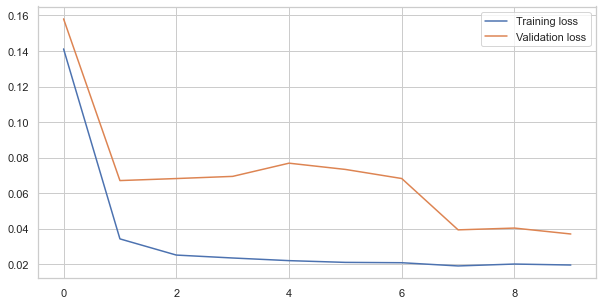

In [168]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [169]:
#Predicting...
#Libraries that will help us extract only business days in the US.
#Otherwise our dates would be wrong when we look back (or forward).  
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_td = CustomBusinessDay(calendar=USFederalHolidayCalendar())

In [170]:
#Remember that we can only predict one day in future as our model needs 3 variables
#as inputs for prediction. We only have all 3 variables until the last day in our dataset.
n_past = 1
n_days_for_prediction=60  #let us predict past 15 days

In [171]:
predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_td).tolist()
print(predict_period_dates)

[Timestamp('2018-03-27 00:00:00', freq='C'), Timestamp('2018-03-28 00:00:00', freq='C'), Timestamp('2018-03-29 00:00:00', freq='C'), Timestamp('2018-03-30 00:00:00', freq='C'), Timestamp('2018-04-02 00:00:00', freq='C'), Timestamp('2018-04-03 00:00:00', freq='C'), Timestamp('2018-04-04 00:00:00', freq='C'), Timestamp('2018-04-05 00:00:00', freq='C'), Timestamp('2018-04-06 00:00:00', freq='C'), Timestamp('2018-04-09 00:00:00', freq='C'), Timestamp('2018-04-10 00:00:00', freq='C'), Timestamp('2018-04-11 00:00:00', freq='C'), Timestamp('2018-04-12 00:00:00', freq='C'), Timestamp('2018-04-13 00:00:00', freq='C'), Timestamp('2018-04-16 00:00:00', freq='C'), Timestamp('2018-04-17 00:00:00', freq='C'), Timestamp('2018-04-18 00:00:00', freq='C'), Timestamp('2018-04-19 00:00:00', freq='C'), Timestamp('2018-04-20 00:00:00', freq='C'), Timestamp('2018-04-23 00:00:00', freq='C'), Timestamp('2018-04-24 00:00:00', freq='C'), Timestamp('2018-04-25 00:00:00', freq='C'), Timestamp('2018-04-26 00:00:00'

In [172]:
#Make prediction
prediction = model.predict(Xtrain[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

In [173]:
prediction

array([[2.2529864],
       [2.2494779],
       [2.249519 ],
       [2.2457519],
       [2.2477279],
       [2.2540903],
       [2.2629318],
       [2.2685406],
       [2.2710834],
       [2.2771242],
       [2.2874522],
       [2.2976103],
       [2.3190784],
       [2.3487844],
       [2.3770041],
       [2.4034252],
       [2.418872 ],
       [2.4233522],
       [2.416355 ],
       [2.4058444],
       [2.389124 ],
       [2.3673565],
       [2.3447342],
       [2.3212922],
       [2.2783709],
       [2.2243438],
       [2.1714673],
       [2.114668 ],
       [2.050137 ],
       [1.9873043],
       [1.9421066],
       [1.9080638],
       [1.8889751],
       [1.8880073],
       [1.9002756],
       [1.915283 ],
       [1.9279128],
       [1.944952 ],
       [1.9798015],
       [2.034503 ],
       [2.0827847],
       [2.1316028],
       [2.1787643],
       [2.2204728],
       [2.2496538],
       [2.2761474],
       [2.2902832],
       [2.301191 ],
       [2.3179154],
       [2.342845 ],


In [174]:
#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, stock_data.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

In [175]:
y_pred_future

array([174.60506, 174.46945, 174.47104, 174.32542, 174.40181, 174.64772,
       174.98947, 175.20625, 175.30453, 175.53802, 175.93723, 176.32986,
       177.15965, 178.30785, 179.39859, 180.41982, 181.01688, 181.19003,
       180.91957, 180.51332, 179.86705, 179.0257 , 178.15129, 177.24521,
       175.58621, 173.49797, 171.45418, 169.25877, 166.76453, 164.33592,
       162.58894, 161.27312, 160.53531, 160.4979 , 160.97209, 161.55215,
       162.04033, 162.69891, 164.04593, 166.16025, 168.02643, 169.91335,
       171.73624, 173.34834, 174.47624, 175.50027, 176.04666, 176.46826,
       177.1147 , 178.07828, 178.97363, 179.6807 , 180.02626, 180.11366,
       179.95369, 179.79225, 179.40224, 178.49696, 176.99086, 176.01373],
      dtype=float32)

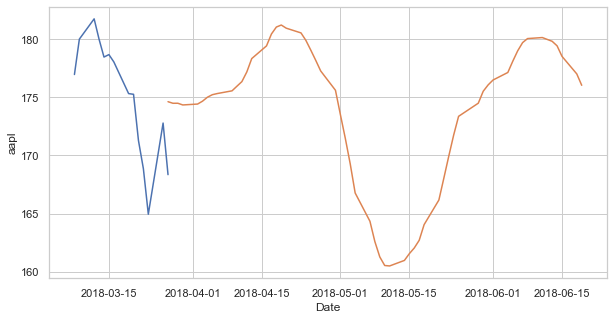

In [176]:
sns.set(rc={'figure.figsize':(10,5)})
sns.set_style('whitegrid')
# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Adj. Close':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])


original = stock_data_ori[['Date', 'aapl']]
original['Date'] = pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2018-03-08']

sns.lineplot(original['Date'], original['aapl'])
sns.lineplot(df_forecast['Date'], df_forecast['Adj. Close']);

In [255]:
start_pred ="2018-03-27"
end_pred ="2018-06-19"

#original apple price from 
aapl_price = pd.read_csv("HistoricalData_aapl.csv", usecols=["Date", "Close/Last"])
aapl_price["Date"] = pd.to_datetime(aapl_price['Date'])
aapl_price["Date"] = aapl_price["Date"].dt.strftime("%Y-%m-%d")
aapl_price["Date"] = pd.to_datetime(aapl_price['Date'])
aapl_price["Close/Last"] = aapl_price["Close/Last"].replace({'\$':''}, regex = True)
aapl_price = aapl_price.rename(columns={"Close/Last": "aapl_ori"})
aapl_price['aapl_ori'] = aapl_price['aapl_ori'].astype(float, errors = 'raise')
aapl_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1260 entries, 0 to 1259
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1260 non-null   datetime64[ns]
 1   aapl_ori  1260 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.8 KB


In [256]:
aapl_price_ = (aapl_price['Date'] >= start_pred) & (aapl_price['Date'] <= end_pred)
aapl_price_

0       False
1       False
2       False
3       False
4       False
        ...  
1255    False
1256    False
1257    False
1258    False
1259    False
Name: Date, Length: 1260, dtype: bool

In [257]:
aapl_price_ori = aapl_price.loc[aapl_price_]
aapl_price_ori

,Date,aapl_ori
300,2018-03-27,42.09
301,2018-03-28,41.62
302,2018-03-29,41.95
303,2018-04-02,41.67
304,2018-04-03,42.10
305,2018-04-04,42.90
306,2018-04-05,43.20
307,2018-04-06,42.10
308,2018-04-09,42.51
309,2018-04-10,43.31


In [253]:
cols = ["Date", "Adj. Close"]
aapl = aaple[cols]
aapl_ = (aapl['Date'] >= start_pred) & (aapl['Date'] <= end_pred)
aapl__ = aapl.loc[aapl_]
print(aapl__.shape)
aapl__

(1, 2)


,Date,Adj. Close
2031,2018-03-27,168.34


In [191]:
df_forecast

,Date,Adj. Close
0,2018-03-27,174.605057
1,2018-03-28,174.469452
2,2018-03-29,174.471039
3,2018-03-30,174.325424
4,2018-04-02,174.401810
5,2018-04-03,174.647720
6,2018-04-04,174.989471
7,2018-04-05,175.206253
8,2018-04-06,175.304535
9,2018-04-09,175.538025


In [17]:
# ---- Train generator
train_generator = TimeseriesGenerator(train_scaled, train_scaled, length=sequence_len,  batch_size=batch_size)
test_generator  = TimeseriesGenerator(test_scaled,  test_scaled,  length=sequence_len,  batch_size=batch_size)

In [18]:
x,y=train_generator[0]
print(f'Nombre de train batchs disponibles : ', len(train_generator))
print('batch x shape : ',x.shape)
print('batch y shape : ',y.shape)
x,y=train_generator[0]

Nombre de train batchs disponibles :  51
batch x shape :  (32, 16, 3)
batch y shape :  (32, 3)


In [19]:
print(x[0])
print(y[0])

[[-1.71602994  0.78169126 -0.09067774]
 [-1.71375469 -0.0525906   0.08669953]
 [-1.70721335 -0.0783774   0.34238868]
 [-1.66815489  2.21041484  2.2436736 ]
 [-1.66753868  0.19550082 -0.01509953]
 [-1.64886267  2.29894514  1.0154485 ]
 [-1.64023568  0.90896782  0.43549534]
 [-1.63710721  0.09174105  0.12470501]
 [-1.6318931   0.13730935  0.24043769]
 [-1.64497579  0.46837015 -0.78353746]
 [-1.64208432  0.26850138  0.11216527]
 [-1.64364856  0.28586874 -0.13859771]
 [-1.6411363  -0.18103219  0.09066777]
 [-1.65251303  0.75123232 -0.69301041]
 [-1.64066229  0.30930147  0.61842807]
 [-1.62355052  0.93561939  0.90242111]]
[-1.61876301  0.91566975  0.21333863]


In [32]:
bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=directory, verbose=0, save_best_only=True)

In [33]:
model.compile(optimizer='adam', 
              loss='mse', 
              metrics   = ['mae'] )

In [34]:
%%time
history=model.fit(train_generator, 
                  epochs  = epochs, 
                  verbose = fit_verbosity,
                  validation_data = test_generator,
                  callbacks = [bestmodel_callback])

Epoch 1/10
49/51 [===========================>..] - ETA: 0s - loss: 0.7505 - mae: 0.6258WARNING:tensorflow:From D:\Deep-Learning\env\lib\site-packages\tensorflow\python\training\tracking\tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: D:/Deep-Learning/stock-price-LSTM\RNN-LSTM on 20220104 at 20-56-PM\assets
51/51 [==============================] - 6s 113ms/step - loss: 0.7503 - mae: 0.6231 - val_loss: 0.4560 - val_mae: 0.5450
Epoch 2/10
51/51 [==============================] - 1s 13ms/step - loss: 0.5388 - mae: 0.4902 - val_loss: 1.7010 - val_mae: 0.9434
Epoch 3/10
51/51 [==============================] - 1s 13ms/step - loss: 0.5109

In [ ]:
#plt(history,plot={'loss':['loss','val_loss'], 'mae':['mae','val_mae']}, save_as='01-history')
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend();

In [ ]:
loaded_model = tf.keras.models.load_model(f'{directory}/best_model.h5')

In [ ]:
s=random.randint(0,len(dataset_test)-sequence_len)

sequence      = dataset_test[s:s+sequence_len]
sequence_true = dataset_test[s:s+sequence_len+1]

pred = loaded_model.predict( np.array([sequence]) )

# ---- Show result
pwk.plot_multivariate_serie(sequence_true, predictions=pred, labels=features, save_as='02-prediction-norm')